In [163]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "llama3.2",
    reasoning=False,
    temperature = 0.1,
)

In [164]:
from typing_extensions import Literal
from pydantic import BaseModel, Field


class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )


In [165]:
llm_router = llm.with_structured_output(Router)
llm_router

RunnableBinding(bound=ChatOllama(model='llama3.2', reasoning=False, temperature=0.1), kwargs={'format': {'description': 'Analyze the unread email and route it according to its content.', 'properties': {'reasoning': {'description': 'Step-by-step reasoning behind the classification.', 'title': 'Reasoning', 'type': 'string'}, 'classification': {'description': "The classification of an email: 'ignore' for irrelevant emails, 'notify' for important information that doesn't need a response, 'respond' for emails that need a reply", 'enum': ['ignore', 'respond', 'notify'], 'title': 'Classification', 'type': 'string'}}, 'required': ['reasoning', 'classification'], 'title': 'Router', 'type': 'object'}, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema'}, 'schema': <class '__main__.Router'>}}, config={}, config_factories=[])
| PydanticOutputParser(pydantic_object=<class '__main__.Router'>)

In [166]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [167]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [168]:
from prompts import triage_system_prompt, triage_user_prompt

In [169]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [170]:
# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

## Main agent, define tools

In [171]:
from langchain_core.tools import tool

In [172]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [173]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"



In [174]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Define tools for managing memory

根本問題：AI 的「失憶症」
大型語言模型 (LLM) 本質上是無狀態 (Stateless) 的。這意味著，你與它進行的每一次對話，對它來說都是一次全新的互動。它不記得你五分鐘前說過的話，更不記得昨天聊天的內容。為了解決這個問題，我們需要為 AI 外掛一個「大腦」或「記憶體」，讓它可以儲存和讀取資訊。
然而，當這個 AI 需要同時服務成千上萬個使用者時，新的問題出現了：
資料隔離: 如何確保使用者 A 的記憶不會被使用者 B 看到或覆寫？
資料組織: 如何有條理地存放不同類型、不同應用的記憶？
這段程式碼，正是為了解決上述兩個問題而設計的精密配置。


`create_manage_memory_tool` 和 `create_search_memory_tool` 這兩個函式，是來自像 LangChain 或 LangGraph 這樣的 AI 框架。它們的作用是將複雜的記憶體操作，*打包成 AI Agent 可以理解和使用的「工具 (Tool)」*。

在 AI Agent 的世界裡，「工具」是賦予 AI 超出語言能力之外的具體技能。例如「上網搜尋」、「執行程式碼」、「計算數學」，以及我們這裡的「存取記憶」。AI Agent 會根據當前任務，自主決定是否以及何時使用哪個工具。

1. 
```python
manage_memory_tool = create_manage_memory_tool(...)
```
作用: 創建一個名為 manage_memory 的工具。此工具負責寫入 (Write) 記憶，包含新增、更新或刪除資訊。當 AI 判斷「我需要記住這件事」時，就會呼叫它。
權限: 這是對記憶體的「寫入權限」。

2. 

```python
search_memory_tool = create_search_memory_tool(...)
```
作用: 創建一個名為 search_memory 的工具。此工具負責讀取 (Read) 記憶，從記憶庫中查詢資訊。當 AI 判斷「我需要回憶某件事」時，就會呼叫它。

權限: 這是對記憶體的「讀取權限」。


其都有 `namespace` 概念

是一個定義資料存放「唯一位址」的階層式結構。可以把它想像成一個資料庫中的「複合主鍵 (Composite Primary Key)」。範例

```python
namespace=("email_assistant", "{langgraph_user_id}", "collection")
```


這是一個三層結構的元組 (tuple)，每一層都有其特定的隔離作用：

- 第一層: "email_assistant" - 應用層隔離

    - 目的: 區分不同的 AI 應用。假設您的公司開發了一個「郵件助理」和一個「客服助理」，您不希望它們的記憶混在一起。這一層確保了「郵件助理」的記憶只會存放在標示為 email_assistant 的區域。
    - 比喻: 像是銀行保險庫中的一個特定區域，專門保留給「VIP 客戶」。

- 第二層: "{langgraph_user_id}" - 使用者層隔離 (多租戶核心)

    - 目的: 這是實現多租戶 (Multi-tenancy) 的關鍵。{langgraph_user_id} 是一個動態佔位符 (Dynamic Placeholder)。在實際運行中，當一個請求進來時，LangGraph 框架或您的後端應用程式，必須提供當前使用者的唯一身份 ID (例如從登入 session、API 金鑰或聊天室 ID 中取得)，並用這個 ID 替換掉佔位符。
    - 運作方式:
        - 當使用者 Alice (ID: user_a_123) 互動時，記憶路徑會變成 ("email_assistant", "user_a_123", "collection")。
        - 當使用者 Bob (ID: user_b_456) 互動時，記憶路徑會變成 ("email_assistant", "user_b_456", "collection")。
    - 結果: 由於每個使用者的路徑都是獨一無二的，他們的資料被儲存在完全隔離的空間中，從根本上杜絕了資料洩漏的風險。
    - 比喻: 就像在銀行的「VIP 客戶」區中，為每一位客戶分配一個獨一無二的保險箱，並用他們的身份證號碼作為編號。

- 第三層: "collection" - 資料類型層隔離
    - 目的: 在單一使用者的記憶空間內，進一步對資料進行分類。這裡統一使用 "collection"，但您可以根據需求擴展。例如，可以設計成：
        - ("email_assistant", "{user_id}", "profile"): 存放使用者偏好、姓名等基本資料。
        - ("email_assistant", "{user_id}", "chat_history"): 存放完整的對話歷史。
        - ("email_assistant", "{user_id}", "documents"): 存放使用者上傳的文件摘要。
    - 比喻: 就像在您個人的保險箱內，再使用不同的盒子來分別存放「珠寶」、「重要文件」和「現金」。


3. 完整的運作流程
    1. 使用者請求: 使用者 `Alice` (ID: `user_a_123`) 透過前端介面發送訊息：「請記住我的航班號是 BR-857」。
    2. 後端接收: Web 伺服器（例如 Flask, FastAPI）接收到請求。它透過認證機制得知當前使用者是 `user_a_123。`
    3. 呼叫 Agent: 伺服器將訊息和使用者 ID (`user_a_123`) 一同傳遞給 LangGraph Agent。
    4. Agent 決策: Agent 內部的 LLM 分析訊息後，認為需要儲存資訊，決定呼叫 `manage_memory` 工具。
    5. 動態替換: LangGraph 框架在執行工具前，讀取 `namespace` 配置，並將佔位符 `{langgraph_user_id}` 替換為實際的 `user_a_123。`
    6. 執行工具: `manage_memory_tool` 被觸發，它將「航班號: BR-857」這條資訊，寫入到後端記憶體儲存（如 Redis, Postgres Vector DB）中，其位址標籤為 `("email_assistant", "user_a_123", "collection")`。
    7. 未來查詢: 當 Alice 稍後問「我的航班號是多少？」時，`search_memory_tool` 會在 `("email_assistant", "user_a_123", "collection")` 這個專屬路徑下查找，從而準確地取回她的資訊。


In [175]:
from langgraph.store.memory import InMemoryStore

In [176]:
store = InMemoryStore(
    index={"embed": "ollama:nomic-embed-text"}
)

In [177]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [178]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    ),
    name="manage_memory"
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    ),
    name="search_memory"
)

In [179]:
print(manage_memory_tool.name)

manage_memory


In [180]:
print(manage_memory_tool.description)

Create, update, or delete a memory to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [181]:
manage_memory_tool.args

{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Content'},
 'action': {'default': 'create',
  'enum': ['create', 'update', 'delete'],
  'title': 'Action',
  'type': 'string'},
 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Id'}}

In [182]:
search_memory_tool.name

'search_memory'

In [183]:
search_memory_tool.description

'Search your long-term memories for information relevant to your current context.'

In [184]:
search_memory_tool.args

{'query': {'title': 'Query', 'type': 'string'},
 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'},
 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'},
 'filter': {'anyOf': [{'additionalProperties': True, 'type': 'object'},
   {'type': 'null'}],
  'default': None,
  'title': 'Filter'}}

In [185]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

## Main agent, define prompt

In [186]:
from langgraph.prebuilt import create_react_agent
def create_prompt(state):
    print("--- [create_prompt] 接收到的 State 內容 ---")
    # 使用 json.dumps 讓巢狀的字典更容易閱讀
    print(state)
    print("--- State 內容結束 ---")
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

tools=[
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
agent = create_react_agent(
    model="ollama:llama3.2",
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [187]:
config = {"configurable": {"langgraph_user_id": "lance"}}

In [188]:

response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "Jim is my friend"
    }]},
    config
)

--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='Jim is my friend', additional_kwargs={}, response_metadata={}, id='368f3903-cf48-48ac-89c3-ffb567751acd')], 'remaining_steps': 24}
--- State 內容結束 ---


In [189]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Jim is my friend
================================== Ai Message ==================================

{"name": "manage_memory", "parameters": {"action": "update", "id": null, "content": "{"}}


In [190]:
response = agent.invoke(
    {"messages": [{"role": "user", "content": "who is jim?"}]},
    config=config
)

--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='who is jim?', additional_kwargs={}, response_metadata={}, id='89433de6-d842-4034-9e77-41c7c84b2097')], 'remaining_steps': 24}
--- State 內容結束 ---
--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='who is jim?', additional_kwargs={}, response_metadata={}, id='89433de6-d842-4034-9e77-41c7c84b2097'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-08-17T03:05:37.264041632Z', 'done': True, 'done_reason': 'stop', 'total_duration': 167916801, 'load_duration': 25989677, 'prompt_eval_count': 723, 'prompt_eval_duration': 8447984, 'eval_count': 18, 'eval_duration': 132144944, 'model_name': 'llama3.2'}, id='run--d5af2a09-f761-4979-8fa6-8b18c22993d6-0', tool_calls=[{'name': 'search_memory', 'args': {'query': 'jim'}, 'id': '69b3db96-72f3-4472-8737-3d35e0a365ef', 'type': 'tool_call'}], usage_metadata={'input_tokens': 723, 'output_tokens': 18, 'total_

In [191]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

who is jim?
================================== Ai Message ==================================
Tool Calls:
  search_memory (69b3db96-72f3-4472-8737-3d35e0a365ef)
 Call ID: 69b3db96-72f3-4472-8737-3d35e0a365ef
  Args:
    query: jim
================================= Tool Message =================================
Name: search_memory

[]
================================== Ai Message ==================================

It appears that there is no relevant information stored in memory about a person named Jim. If you could provide more context or clarify who Jim is, I'd be happy to try and assist you further.

However, I can suggest checking John's contact list to see if he has any entries for someone named Jim. Here is an example of how I could use the `manage_memory` tool to check:

```
managing_memory()
print(memory[" contacts ])
```

This would print out a list of all the contacts stored in memory, including

## Create the Overall Agent

In [192]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [193]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [194]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [195]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

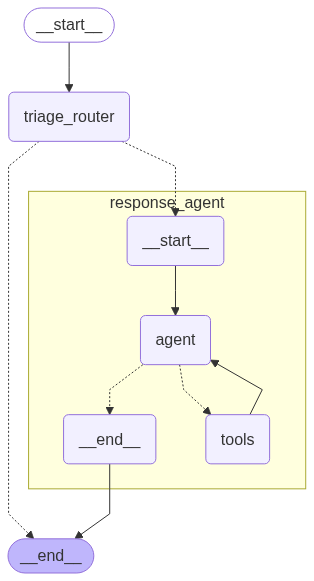

In [196]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [197]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [198]:
response = email_agent.invoke({"email_input": email_input},  config=config)

📧 Classification: RESPOND - This email requires a response
--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='Respond to the email {\'author\': \'Alice Smith <alice.smith@company.com>\', \'to\': \'John Doe <john.doe@company.com>\', \'subject\': \'Quick question about API documentation\', \'email_thread\': "Hi John,\\n\\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\\n\\nSpecifically, I\'m looking at:\\n- /auth/refresh\\n- /auth/validate\\n\\nThanks!\\nAlice"}', additional_kwargs={}, response_metadata={}, id='66a4f435-4961-4b3c-990d-889ef54e0452')], 'remaining_steps': 24}
--- State 內容結束 ---
--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='Respond to the email {\'author\': \'Alice Smith <alice.smith@company.com>\', \'to\': \'John Doe <john.doe@company.com>\', \'subject\': \

In [199]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (ea18378d-1919-41f0-9f98-012546b65cd0)
 Call ID: ea18378d-1919-41f0-9f98-012546b65cd0
  Args:
    content: Hi Alice,

Thank you for bringing this to my attention. I will review the API documentation and get back to you shortly.
Best regards, John Doe
    subject: Re: Quick question about API documentation
    

In [200]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Any update on my previous ask?""",
}

In [201]:
response = email_agent.invoke({"email_input": email_input}, config=config)

📧 Classification: RESPOND - This email requires a response
--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content="Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\\n\\nAny update on my previous ask?'}", additional_kwargs={}, response_metadata={}, id='25fc5f19-b23a-4a6e-9281-9c7bc3515ee3')], 'remaining_steps': 24}
--- State 內容結束 ---
--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content="Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\\n\\nAny update on my previous ask?'}", additional_kwargs={}, response_metadata={}, id='25fc5f19-b23a-4a6e-9281-9c7bc3515ee3'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-08-17T03:05:42.10878723Z', 'done': True, 'done_reason': 'stop'

In [202]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nAny update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  write_email (ebbaacb7-3b25-4f0d-b509-802635f3dbe0)
 Call ID: ebbaacb7-3b25-4f0d-b509-802635f3dbe0
  Args:
    content: Hi Alice, 

I have not had a chance to follow up on your previous ask yet. I will look into it as soon as possible.
    subject: Follow up
    to: john.doe@company.com
================================= Tool Message =================================
Name: write_email

Email sent to john.doe@company.com with subject 'Follow up'
================================== Ai Message ==================================

I'll manage memory regarding this email response. 
{"email": "Hi Alice, \n\nI have not had a c